# **Tutorial 3: Multi-model Ensembles**

**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas

**Content reviewers:** Younkap Nina Duplex, Zahra Khodakaramimaghsoud, Sloane Garelick, Peter Ohue, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**
In this tutorial, we will analyze climate simulations from five different CMIP6 models developed by various institutions around the world, focusing on historical simulations and low-emissions projections. By the end of this tutorial, you will be able to 
- load CMIP6 Sea Surface Temperature (SST) data from multiple models;
- calculate the SST anomalies, and understand the concept of temperature anomaly in relation to a base period

# **Setup**

    



In [1]:
# !pip install condacolab &> /dev/null        
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

In [2]:
# imports
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric


In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}
%matplotlib inline


In [5]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 


In [6]:
# @title Video 3: Why so many Earth System Models? 
#Tech team will add code to format and display the video

# **Section 1: Load CMIP6 SST Data from Five Models and Three Experiments**
In the previous section, you compared how a single CMIP6 model (*TaiESM1*) simulated past temperature, and how it projected temperature would change under a low-emissions scenario and a high-emissions scenario (*historical*, *SSP1-2.6* and *SSP5-8.5* experiments respectively). 

Now we will start to analyze a **multi-model ensemble** consisting of data from multiple CMIP6 models. For now, we will focus on just the historical simulation and the low-emissions projection.

Your multi-model ensemble will consist of:

*  **Five** different CMIP6 models developed by institutions from a variety of countries: 
  * *TaiESM1* (Research Center for Environmental Changes, Taiwan),
  * *IPSL-CM6A-LR* (Institut Pierre Simon Laplace, France),
  * *GFDL-ESM4* (NOAA Geophysical Fluid Dynamics Laboratory, USA), 
  * *ACCESS-CM2* (CSIRO and ARCCSS, Australia), and 
  * *MPI-ESM1-2-LR* (Max Planck Institute, Germany). 

Note that these are only a subset of the dozens of models, institutes, countries, and experiments that contribute to CMIP6, as discussed in the previous W2D1 Tutorial 2 video. Some of the abbreviations in the model names refer to instutites (*MPI/GFDL*), while some refer to the complexity and version of the model (e.g., Earth System or Climate Model [*ESM/CM*] and low- or high-resolution [*LR/HR*]). There are often several models from a single institute with each having a distinct level of complexity.

In [7]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five models and three experiments
# there are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['IPSL-CM6A-LR', 'GFDL-ESM4', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'TaiESM1']
experiment_ids = ['historical', 'ssp126', 'ssp585']

In [1]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id='tos',
    member_id='r1i1p1f1',
    table_id='Omon',
    grid_label='gn',
    experiment_id = experiment_ids,
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)

NameError: name 'col' is not defined

In [9]:
cat_area = col.search(
    source_id=source_ids,
    variable_id='areacello', # for the coding exercise, ellipses will go after the equals on this line
    member_id='r1i1p1f1',
    table_id='Ofx', # for the coding exercise, ellipses will go after the equals on this line
    grid_label='gn',
    experiment_id = ['historical'], # for the coding exercise, ellipses will go after the equals on this line
    require_all_on = ['source_id']
)

cat_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model,subtree in dt.items():
    metric = dt_area[model]['historical'].ds['areacello']
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


Let's first reproduce the previous tutorial's timeseries of SST from *TaiESM1* through the historical experiment and two future emissions scenarios

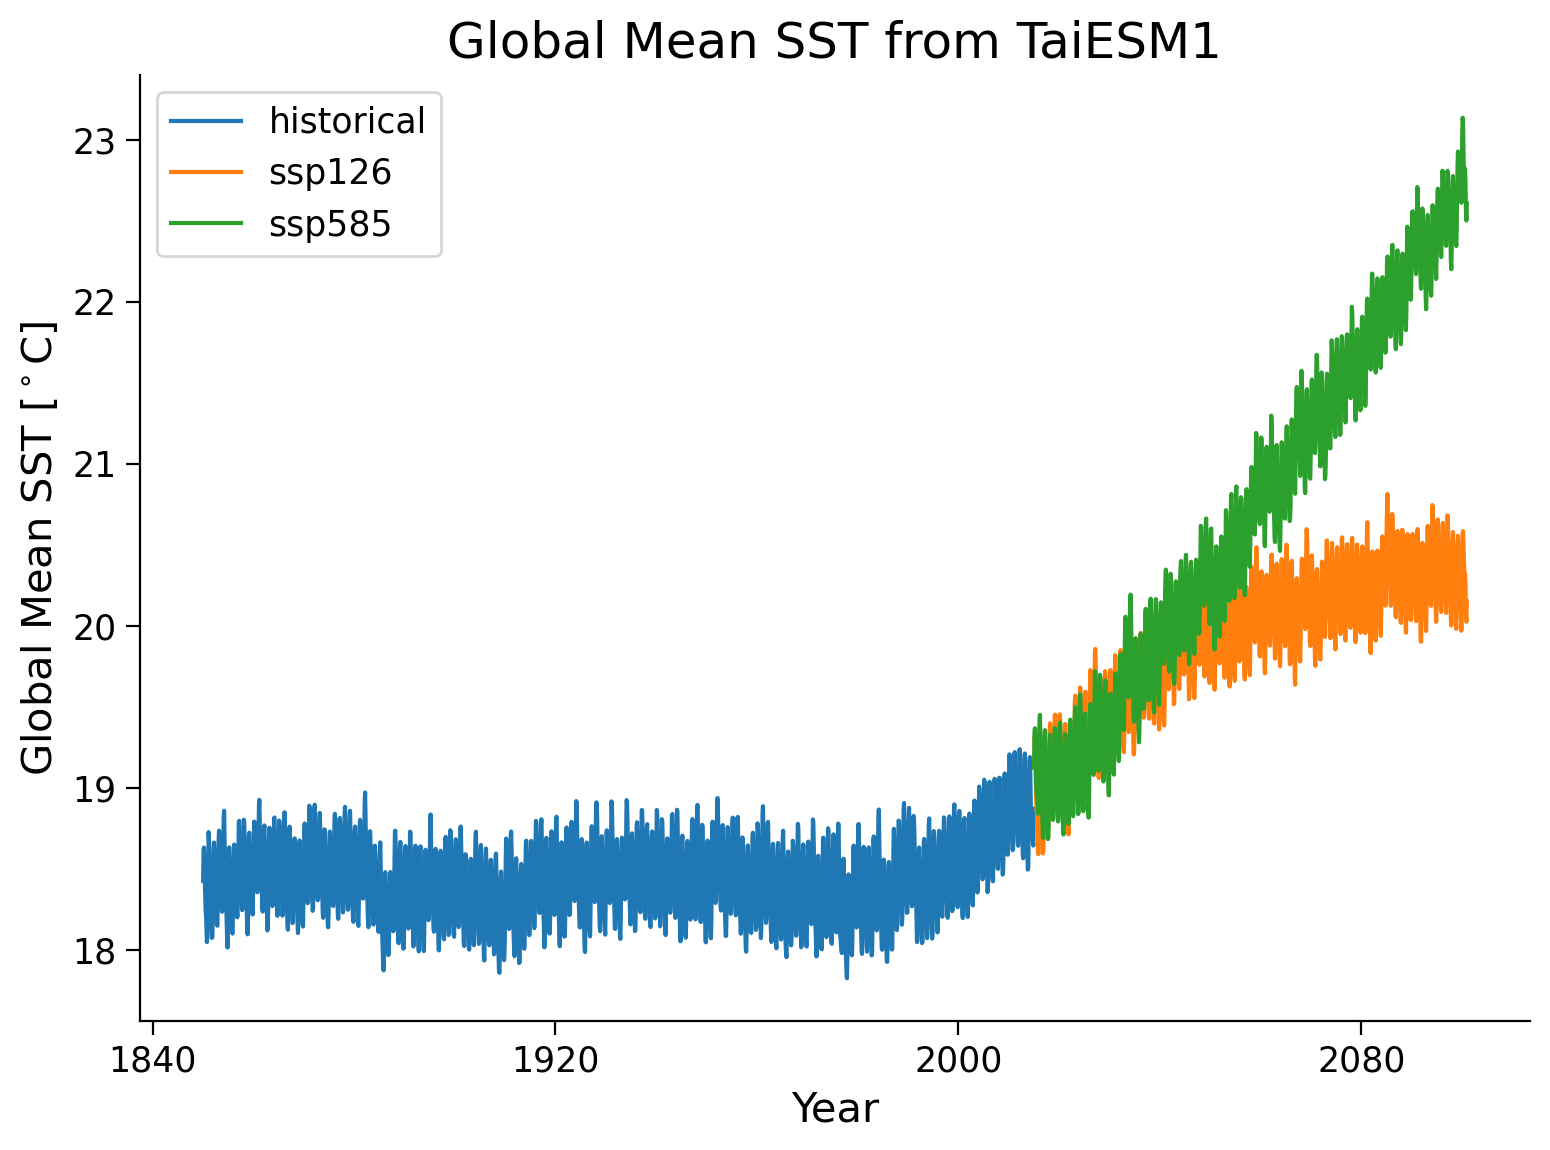

In [10]:
# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

for experiment in ['historical', 'ssp126', 'ssp585']:
    da = dt_gm['TaiESM1'][experiment].ds.tos
    da.plot(label=experiment)
plt.title('Global Mean SST from TaiESM1')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()


### **Coding Exercise 1.1: Combine Past Data and Future Data, and Remove Seasonal Oscillations**

* The historical and projected data are separate time series. Complete the *xr.concat* function to combine the historical and projected data into a single continuous time series for each model?
* The previous timeseries oscillated very rapidly due to Earth's seasonal cycles. Finish the *xarray* *resample* function so that it smooths the monthly data with a one-year running mean? This will make it easier to distinguish the medium- to long-term changes in sea surface temperature.

In [ ]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Combine historical & future (ssp126) data from the same model and smooth with a 1-year running mean")
#################################################

def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        # for each of the models, concatenate its historical and future data
        da_combined = xr.concat(...)
        # plot annual averages
        da_combined.coarsen(...).mean().plot(label=model) 
    
plot_historical_ssp126_combined(dt_gm)

plt.title('Global Mean SST from five CMIP6 models (annually smoothed)')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

In [ ]:
# to_remove solution

def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.coarsen(time=12).mean().tos)

        # for each of the models, concatenate its historical and future data
        da_combined = xr.concat(datasets, dim='time')
        # plot annual averages
        da_combined.plot(label=model) 

plot_historical_ssp126_combined(dt_gm)

plt.title('Global Mean SST from five CMIP6 models (annually smoothed)')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend() 

### **Question 1.1**

1.   Why do you think the global mean temperature varies so much between models?* 

*If you get stuck here, reflect on the videos from earlier today and the tutorials/videos from the Climate Modelling day for inspiration.

In [ ]:
# to_remove explanation

"""
1. Each of these models has slightly different physics, numerics, and discretization. During the Cliamte Modeling, day you showed that Earth's theoretical equilibrium temperature under fixed insolation changes as more details/complexity of the real Earth system are included. Similarly, the small differences between models result in each model having a slightly different equilibrium temperature for a given insolation, which also manifests in these long-term these simulations.
""";

### **Coding Exercise 1.2: Calculate the SST *Anomalies***

As you just saw, the global mean temperature varies between climate models. This is not surprising given the slight differences in physics, numerics, and discretization between each model.

When we are looking at future projections, we care about how the model's *change* relative to their equilibrium/previous state. To do this, we typically subtract a historical reference period from the timeseries, which create a new timeseries which we call the temperature *anomaly* relative to that period. **Recall that you already calculated and used *anomalies* earlier in the course (e.g., on W1D1).**

**Modify the following code to recreate the previous multi-model figure, but now instead plot the global mean sea surface temperature (GMSST) *anomaly* relative the 1950-1980 base period (i.e., subtract the 1950-1980 mean GMSST of each model from that model's timeseries)**

*Hint: you will need to use `ds.sel` to select data during the base period ([see here](https://docs.xarray.dev/en/stable/user-guide/indexing.html#indexing-with-dimension-names) under "Indexing with dimension names" for a helpful example) along with the averaging operator, `mean()`.*

In [ ]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Adapt the previous figure to plot the anomaly of global mean sea surface temperature relative to the 1950-1980 period")
#################################################

# calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # find the temporal average over the desired reference period
        ref = ...
        dt_out[model] = subtree - ref
    return dt_out

dt_gm_anomaly = datatree_anomaly(dt_gm)

plot_historical_ssp126_combined(dt_gm_anomaly)

plt.title('Global Mean SST Anomaly from five CMIP6 models (base period: 1950 to 1980)')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

In [ ]:
# to_remove solution

# calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # find the temporal average over the desired reference period
        ref = dt[model]['historical'].ds.sel(time=slice('1950', '1980')).mean() 
        dt_out[model] = subtree - ref
    return dt_out

dt_gm_anomaly = datatree_anomaly(dt_gm)

plot_historical_ssp126_combined(dt_gm_anomaly)

plt.title('Global Mean SST Anomaly from five CMIP6 models (base period: 1950 to 1980)')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

### **Questions 1.2**

1.  How does this figure compare to the previous one where the reference period was not subtracted?
2.  This figure uses the reference period of 1950-1980 for its anomaly calculation. How does the variability across models 100 years before the base period (1850) compare to the variability 100 years after the base period (2080)? Why do you think this is?


In [ ]:
# to_remove explanation

"""
1. The models agree much better across this time period, particularly in the reference period and during the rapid warming phase projected in the near future.
2. There is variability at both ends of the scale, but the future (2080) period has more inter-model variability than the past (1850) period. This is likely because each of these models has a simulates a unique climate system, as we found in the last question, which leads to different responses to the rapid  changes in effective radiative forcing that are projected in the near future. 
""";

# **Summary**

In this tutorial, we expanded on the previous examination of the *TaiESM1* CMIP6 model, to a multi-model ensemble comprising of five different CMIP6 models (*TaiESM1*, *IPSL-CM6A-LR*, *GFDL-ESM4*, *ACCESS-CM2*, and *MPI-ESM1-2-LR*) developed by institutions from various countries. We focused on the historical simulation and the low-emissions projection, providing a broader perspective on variability in climate modeling. We also learned about the varying complexities between these models.